In [2]:
!pip install bitstring

     |████████████████████████████████| 60 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 4.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bitarray: filename=bitarray-2.9.2-cp38-cp38-linux_armv7l.whl size=237953 sha256=e5cb9d09261bc935767a8d3cd551d415d58e1da192dec9262130154f04aadd49
  Stored in directory: /root/.cache/pip/wheels/1b/a0/3d/5beb80b2e592451e0a9ae012747097f85f3ce909764b0ef631
Successfully built bitarray
You should consider upgrading via the '/usr/local/share/pynq-venv/bin/python3 -m pip install --upgrade pip' command.


In [8]:
import os
import glob
import cv2
import numpy as np
import time
import torch
import torch.nn as nn

from matplotlib import pyplot as plt

from driver.driver import io_shape_dict
from driver.driver_base import FINNExampleOverlay
from utils import (clip_coords, scale_coords, letterbox, 
                   xywh2xyxy, non_max_suppression,  
                   visualize_boxes)
from models import Detect

In [9]:
driver = FINNExampleOverlay(
    bitfile_name="./bitfile/finn-accel.bit",
    platform="zynq-iodma",
    io_shape_dict=io_shape_dict,
    batch_size=1,
    runtime_weight_dir="runtime_weights/",
)

In [29]:
test_img_folder = "../../inputs/images/"
test_img_paths = glob.glob(test_img_folder + "*.jpg")
output_path = "../../test_outputs/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [30]:
names = ['face']
nc  = 1
anchors = np.array([[10,14,23,27,37,58]]) / np.array([32])
scale = np.load("./bitfile/scale.npy")
detect_head = Detect(nc, anchors)

1 face


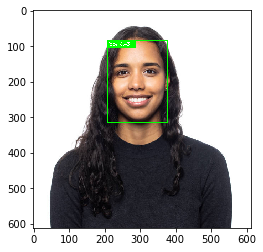

12 face


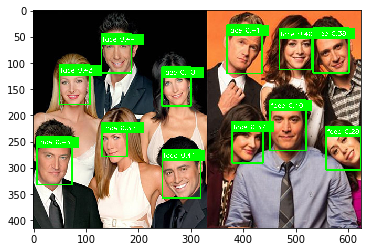

8 face


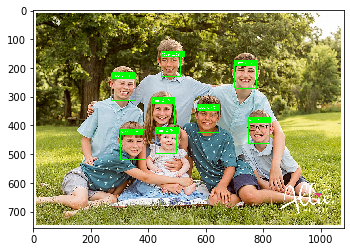

6 face


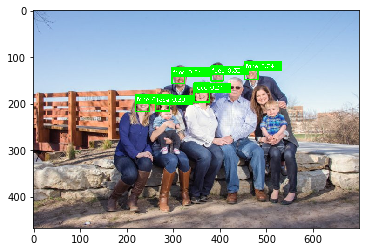

In [31]:
for number, test_img_path in enumerate(test_img_paths):
    img_org = cv2.imread(test_img_path)
    img = img_org.copy()
    
    h, w, _ = img_org.shape
    img, ratio, (dw, dh) = letterbox(img, (416,416), auto=False)
    
    img = img[:, :, ::-1]
    img = img.astype(np.uint8)
    driver_in = np.expand_dims(img, 0)

    output = driver.execute(driver_in)
    output = scale*output
    output = output.transpose(0,3,1,2)

    output = torch.from_numpy(output)
    pred = detect_head([output])[0]

    pred = non_max_suppression(pred, conf_thres=0.20, iou_thres=0.10, classes=None, max_det=1000)

    boxes_detected, class_names_detected, probs_detected = [], [], []
    # Process predictions
    for i, det in enumerate(pred):  # per image
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape, det[:, :4], img_org.shape).round()
            # Print results
            for c in np.unique(det[:, -1]):
                n = (det[:, -1] == c).sum()  # detections per class
                print(f"{n} {names[int(c)]}")  # add to string
            # Write results
            for *xyxy, conf, cls in reversed(det):
                c = int(cls)  # integer class
                label = f'{names[c]} {conf:.2f}'
                boxes_detected.append(xyxy)
                class_names_detected.append(names[c])
                probs_detected.append(conf)

    # Visualize.
    image_boxes = visualize_boxes(img_org, boxes_detected, class_names_detected, probs_detected)
    cv2.imwrite(output_path+f"{number}.jpg", image_boxes)
    
    plt.imshow(cv2.cvtColor(image_boxes, cv2.COLOR_BGR2RGB))
    plt.show()


In [ ]:
!pip install requests


In [12]:
!pwd


/home/xilinx/jupyter_notebooks/finn-quantized-yolo/src/deploy


In [15]:
import requests

# URL of the image to be downloaded
image_url = 'https://i.pinimg.com/originals/3a/7f/15/3a7f1529ad61ce21cd446b31e669b13f.jpg'
# Local path where the image will be saved
local_filename = '/home/xilinx/jupyter_notebooks/finn-quantized-yolo/inputs/images/3a7f1529ad61ce21cd446b31e669b13f.jpg'